In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from datetime import datetime  # Importa datetime
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score
import optuna
import pandas as pd
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
warnings.filterwarnings("ignore")


# Modelo ML para determinar variacion de stock migratorio con cambios en los indicadores 

El modelo buscará predecir el stock migratorio de Argentina ante variaciones de los indicadores estudiados. Se utilizaron datos de stock migratorio e indicadores de todos los paises del dataset de la ONU para el entrenamiento del modelo. 
A partir del dataset de stock migratorio de las naciones unidas y los valores de indicadores del banco mundial se contruyó una tabla para el entrenamiento del modelo. 

Para obtener el dataset de trabajo se realizaron las siguientes transformaciones:
* se agrupó el dataset de naciones unidas por país de destino, sumando las cantidades de todos los paises de origen, obteniendo el valor de stock de inmigrantes por país por año
* se agregaron a la tabla los valores de los indicadores del banco mundial.
Todo este analisis para llegar al datset esta en el notebook 'EDA_datasets_internacionales'.

### 1. Ingesta de dataset con datos para entrenamiento del modelo

In [2]:
Stock_migrantes_agrupado=pd.read_csv('Stock_migrantes_agrupado')

In [3]:
Stock_migrantes_agrupado=Stock_migrantes_agrupado.drop(columns='Unnamed: 0')

In [4]:
Stock_migrantes_agrupado.head(3)

,ISO3_dest,Year,ingreso_stock,Country Code,Ingresos,Electricidad,Contaminación,Crecimiento PBI,Crecimiento PBI per cápita,Desempleo Hombre,Desempleo mujeres,Gasto PBI,Importaciones,Migracion neta,Desempleados con educación avanzada,Tasa de cambio,Pobreza,Mortalidad
0,ABW,1990,11099,ABW,NaN,100.000000,NaN,3.961402,2.195805,NaN,NaN,NaN,5.810000e+08,879.0,NaN,1.79,NaN,7.100
1,ABW,1995,19002,ABW,NaN,100.000000,NaN,2.547144,-0.567202,NaN,NaN,NaN,1.597000e+09,1598.0,NaN,1.79,NaN,6.366
2,ABW,2000,26897,ABW,NaN,91.660398,NaN,7.616589,4.918354,6.5,NaN,NaN,2.582000e+09,1235.0,NaN,1.79,NaN,6.335


In [5]:
Stock_migrantes_agrupado.isna().sum()

ISO3_dest                                 0
Year                                      0
ingreso_stock                             0
Country Code                            112
Ingresos                               1515
Electricidad                            315
Contaminación                           446
Crecimiento PBI                         254
Crecimiento PBI per cápita              255
Desempleo Hombre                        880
Desempleo mujeres                       494
Gasto PBI                               894
Importaciones                           260
Migracion neta                          112
Desempleados con educación avanzada    1172
Tasa de cambio                          234
Pobreza                                1383
Mortalidad                              139
dtype: int64

In [6]:
Stock_migrantes_agrupado.shape

(1610, 18)

#### 1.a Elimino filas que tengan menos valores no nulos que el umbral

In [7]:
umbral = len(Stock_migrantes_agrupado.columns) * 0.7
Stock_migrantes_agrupado_sin_na= Stock_migrantes_agrupado.dropna(thresh=umbral)

In [8]:
Stock_migrantes_agrupado_sin_na.shape

(1039, 18)

#### 1.b Imputo datos faltantes en las columnas remanentes con KNN

In [9]:
# columnas a imputar 
columns_to_impute = ['ingreso_stock', 'Ingresos',
       'Electricidad', 'Contaminación', 'Crecimiento PBI',
       'Crecimiento PBI per cápita', 'Desempleo Hombre', 'Desempleo mujeres',
       'Gasto PBI', 'Importaciones',
       'Desempleados con educación avanzada', 'Tasa de cambio', 'Pobreza',
       'Mortalidad']

# Copio el DataFrame original para no modificarlo directamente
Stock_migrantes_agrupado_sin_na_imputed =Stock_migrantes_agrupado_sin_na.copy()

# Creo una instancia de KNNImputer
imputer = KNNImputer(n_neighbors=5)  # Elige el número de vecinos que deseas considerar

# fitteo los datos utilizando KNNImputer
Stock_migrantes_agrupado_sin_na_imputed[columns_to_impute] = imputer.fit_transform(Stock_migrantes_agrupado_sin_na_imputed[columns_to_impute])

In [10]:
# Ordeno el DataFrame por la columna 'Year'
Stock_migrantes_agrupado_sin_na_imputed.sort_values('Year', inplace=True)

# Resseteo el índice
Stock_migrantes_agrupado_sin_na_imputed.reset_index(drop=True, inplace=True)

In [11]:
Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock']=Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock'].astype(int)

In [12]:
Stock_migrantes_agrupado_sin_na_imputed.columns

Index(['ISO3_dest', 'Year', 'ingreso_stock', 'Country Code', 'Ingresos',
       'Electricidad', 'Contaminación', 'Crecimiento PBI',
       'Crecimiento PBI per cápita', 'Desempleo Hombre', 'Desempleo mujeres',
       'Gasto PBI', 'Importaciones', 'Migracion neta',
       'Desempleados con educación avanzada', 'Tasa de cambio', 'Pobreza',
       'Mortalidad'],
      dtype='object')

### 2. Modelos de ML

#### 2.1 Preparacion de datos de train y test para probar los modelos:

Separamos los datos en train y test y se hace un escalamiento de las features para aplicarlo en algunos modelos. 

In [13]:
# Definir features y target
X = Stock_migrantes_agrupado_sin_na_imputed.drop(['ingreso_stock','Migracion neta','Country Code','Tasa de cambio','Desempleo mujeres','Desempleo Hombre','Contaminación','Crecimiento PBI','Gasto PBI'], axis=1)  # Características excepto 'Migracion neta' y 'Country Code'
y = Stock_migrantes_agrupado_sin_na_imputed['ingreso_stock']  # Etiquetas
# Dividir los datos en conjuntos de entrenamiento y prueba y hacer dummies
X = pd.get_dummies(X, columns=['ISO3_dest'])

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

#### 2.2 Regresion lineal multiple

In [14]:
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression


# La función objetivo para la optimización de Optuna
def objective(trial):
    # No hay hiperparámetros específicos para ajustar en LinearRegression, pero puedes incluir transformaciones de características si es necesario.
    
    lr_model = LinearRegression()
    lr_model.fit(X_train_scaled, y_train)
    y_pred = lr_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1)  # No hay hiperparámetros para ajustar en LinearRegression, así que solo ejecutamos una vez.

# Crear el modelo final con los datos de entrenamiento
final_lr_model = LinearRegression()
final_lr_model.fit(X_train_scaled, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = final_lr_model.predict(X_test_scaled)

# Calcular el MAE y R2 con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print("MAE con regresión múltiple:", mae_final)
print("R-squared (R2) con regresión múltiple:", r2)

[I 2023-11-29 09:30:02,923] A new study created in memory with name: no-name-970c29c7-802a-4e00-8c8f-8c15c18a0d42
[I 2023-11-29 09:30:03,447] Trial 0 finished with value: 558596.860913815 and parameters: {}. Best is trial 0 with value: 558596.860913815.


MAE con regresión múltiple: 558596.860913815
R-squared (R2) con regresión múltiple: 0.9098473955194447


Se obtiene un valor de r2 alto, pero el valor de Mae es muy alto tambien. 

#### 2.3 Regresion lineal multiple con regularizacion de Ridge

In [15]:

import optuna
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score


# La función objetivo para la optimización de Optuna
def objective(trial):
    alpha = trial.suggest_float('alpha', 0.01, 10.0)  # Hiperparámetro de regularización
    
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)
    y_pred = ridge_model.predict(X_test_scaled)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_ridge_model = Ridge(**best_params)
final_ridge_model.fit(X_train_scaled, y_train)
y_pred = final_ridge_model.predict(X_test_scaled)

# Calcular el MAE y R2 con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("MAE con regresión Ridge:", mae_final)
print("R-squared (R2) con regresión Ridge:", r2)

[I 2023-11-29 09:30:03,576] A new study created in memory with name: no-name-00139971-2511-44d7-98b6-b2b955a38919
[I 2023-11-29 09:30:03,630] Trial 0 finished with value: 557043.6442009459 and parameters: {'alpha': 7.470373983308077}. Best is trial 0 with value: 557043.6442009459.
[I 2023-11-29 09:30:03,648] Trial 1 finished with value: 557150.1196842396 and parameters: {'alpha': 3.9729159227563478}. Best is trial 0 with value: 557043.6442009459.
[I 2023-11-29 09:30:03,670] Trial 2 finished with value: 557330.111971405 and parameters: {'alpha': 9.718280850802241}. Best is trial 0 with value: 557043.6442009459.
[I 2023-11-29 09:30:03,692] Trial 3 finished with value: 557052.9823047817 and parameters: {'alpha': 7.610927915621924}. Best is trial 0 with value: 557043.6442009459.
[I 2023-11-29 09:30:03,741] Trial 4 finished with value: 556968.6373637256 and parameters: {'alpha': 5.118802634636344}. Best is trial 4 with value: 556968.6373637256.
[I 2023-11-29 09:30:03,766] Trial 5 finished w

Mejores hiperparámetros: {'alpha': 5.705770823003142}
MAE con regresión Ridge: 556937.944106248
R-squared (R2) con regresión Ridge: 0.9084614180441314


#### 2.4 XGBRegressor

In [17]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }
    
    xgb_model = XGBRegressor(**param)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    return mae

# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_xgb_model = XGBRegressor(**best_params)
best_model = final_xgb_model.fit(X_train, y_train)
y_pred = final_xgb_model.predict(X_test)

# Calcular el MAE con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados



# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("MAE con los mejores hiperparámetros:", mae_final)
print("R-squared (R2):", r2)


[I 2023-11-29 09:30:10,921] A new study created in memory with name: no-name-af2632ff-5f9b-491b-b094-fb72b4fc1460
[I 2023-11-29 09:30:17,521] Trial 0 finished with value: 415051.61124596227 and parameters: {'n_estimators': 1321, 'max_depth': 6, 'learning_rate': 0.07967296031447207}. Best is trial 0 with value: 415051.61124596227.
[I 2023-11-29 09:30:23,799] Trial 1 finished with value: 529399.7860999474 and parameters: {'n_estimators': 1424, 'max_depth': 9, 'learning_rate': 0.07344364186412311}. Best is trial 0 with value: 415051.61124596227.
[I 2023-11-29 09:32:06,836] Trial 26 finished with value: 423807.22845458984 and parameters: {'n_estimators': 1845, 'max_depth': 6, 'learning_rate': 0.1970658807649161}. Best is trial 18 with value: 335695.38763207657.
[I 2023-11-29 09:32:11,249] Trial 27 finished with value: 337405.67396457377 and parameters: {'n_estimators': 1585, 'max_depth': 3, 'learning_rate': 0.15124863873934977}. Best is trial 18 with value: 335695.38763207657.
[I 2023-11-2

Mejores hiperparámetros: {'n_estimators': 1721, 'max_depth': 3, 'learning_rate': 0.1670753729359835}
MAE con los mejores hiperparámetros: 313252.1662938045
R-squared (R2): 0.9702880042420655


#### 2.4 XGBRegressor con cross validation

In [ ]:

warnings.filterwarnings("ignore")
import optuna
from xgboost import XGBRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# Función para optimizar con Optuna y validación cruzada
def objective(trial, X, y):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3)
    }

    xgb_model = XGBRegressor(**param)

    # Validación cruzada
    kf = KFold(n_splits=5, shuffle=False, random_state=42)
    mae_values = []

    for train_index, test_index in kf.split(X):
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        xgb_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=50, verbose=False,
                      eval_metric="mae")

        y_pred = xgb_model.predict(X_valid)
        mae = mean_absolute_error(y_valid, y_pred)
        mae_values.append(mae)

    return sum(mae_values) / len(mae_values)

# Crear un estudio de Optuna
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=100)

# Obtener los mejores hiperparámetros
best_params = study.best_params

# Crear el modelo final con los mejores hiperparámetros
final_xgb_model = XGBRegressor(**best_params)
final_xgb_model.fit(X_train, y_train)

# Realizar predicciones en el conjunto de prueba
y_pred = final_xgb_model.predict(X_test)

# Calcular el MAE con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Imprimir los resultados
print("Mejores hiperparámetros:", best_params)
print("MAE con los mejores hiperparámetros:", mae_final)
print("R-squared (R2):", r2)


[I 2023-11-29 09:38:46,103] A new study created in memory with name: no-name-7a642996-065e-4b64-a68f-3154436c1f02
[I 2023-11-29 09:38:52,498] Trial 0 finished with value: 349533.9717930937 and parameters: {'n_estimators': 190, 'max_depth': 7, 'learning_rate': 0.1050767851538787}. Best is trial 0 with value: 349533.9717930937.
[I 2023-11-29 09:39:11,177] Trial 1 finished with value: 315239.2507687493 and parameters: {'n_estimators': 1331, 'max_depth': 6, 'learning_rate': 0.23316021180747007}. Best is trial 1 with value: 315239.2507687493.
[I 2023-11-29 09:39:25,406] Trial 2 finished with value: 291651.77189811703 and parameters: {'n_estimators': 502, 'max_depth': 4, 'learning_rate': 0.17730725876946948}. Best is trial 2 with value: 291651.77189811703.
[I 2023-11-29 09:39:33,222] Trial 3 finished with value: 323693.99826420087 and parameters: {'n_estimators': 266, 'max_depth': 5, 'learning_rate': 0.1923348792263281}. Best is trial 2 with value: 291651.77189811703.
[I 2023-11-29 09:40:05,

### 3. Evaluación del Modelo

Seleccinamos el modelo XGBoostregresor que dio los mejores parametros r2 y MAE. Realizamos una evaluación del modelo

In [34]:
# Calcular el MAE con el modelo final
mae_final = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [35]:
mae_final

339238.8348335853

In [36]:
results_df = pd.DataFrame({'Y_test': y_test, 'Y_pred': y_pred})

In [37]:
r2

0.9670097361645932

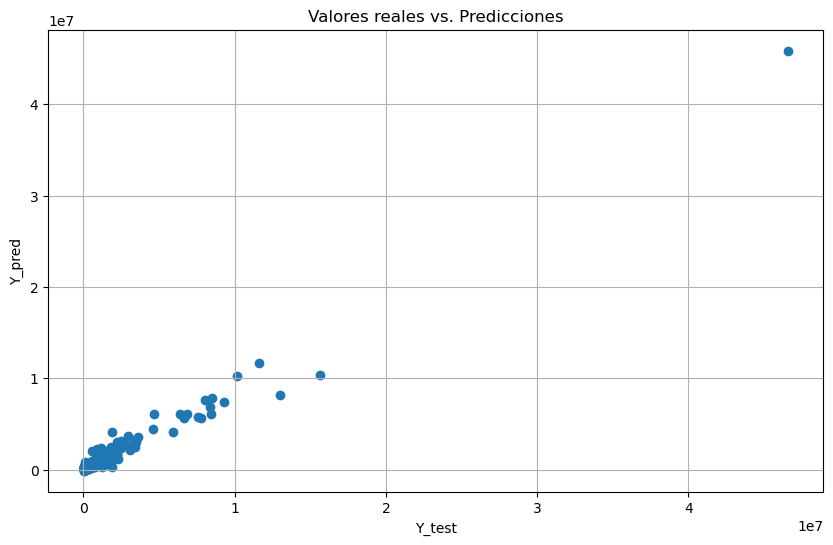

In [38]:
plt.figure(figsize=(10, 6))
plt.scatter(results_df['Y_test'], results_df['Y_pred'])
plt.xlabel('Y_test')
plt.ylabel('Y_pred')
plt.title('Valores reales vs. Predicciones')
plt.grid(True)
plt.show()

Se puede observar que el grafico y_pred vs y_test se aproxima a una recta a 45° lo que sugiere que el modelo esta relizando buenas predicciones. 

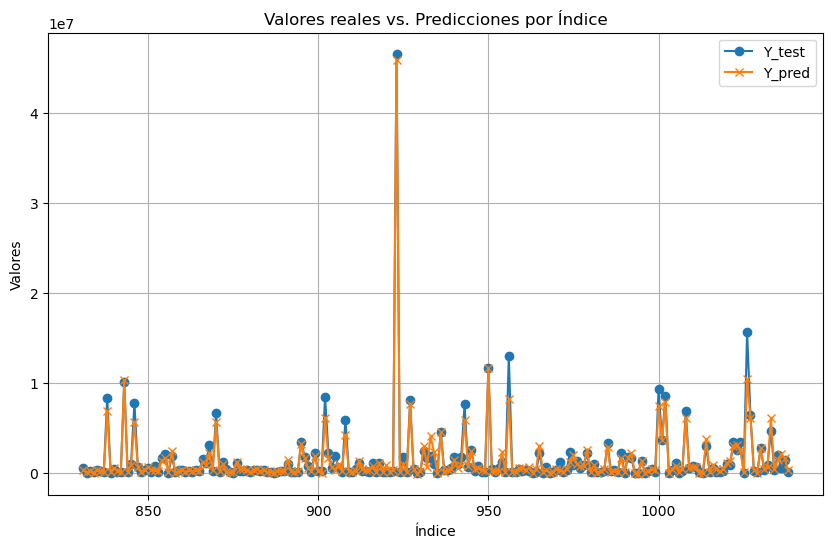

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Y_test'], label='Y_test', marker='o')
plt.plot(results_df.index, results_df['Y_pred'], label='Y_pred', marker='x')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores reales vs. Predicciones por Índice')
plt.legend()
plt.grid(True)
plt.show()

Construimos un dataset con los valores de y_tes e y_pred 

In [49]:
results_df_con_pais = pd.DataFrame({'Y_test': y_test, 'Y_pred': y_pred, 'Pais': X_test['ISO3_dest_ARG'],'Año': X_test['Year'] })

# Filtrar los resultados para un país específico
pais_seleccionado = 1  # Reemplaza con el nombre de tu país de interés
results_arg = results_df_con_pais[results_df_con_pais['Pais'] == pais_seleccionado]

In [50]:
results_arg['diferencia']=results_arg['Y_test'] - results_arg['Y_pred']

In [51]:
results_arg

,Y_test,Y_pred,Pais,Año,diferencia
855,2042145,1631074.375,1,2015,411070.625
899,2237152,1837289.500,1,2020,399862.500


Se observa que los valores predichos son mas bajos que los reales, en el orden del error cuadratico medio. Sin embargo el modelo captó la tendencia de aumento en el stock migratorio. Se utilizará el modelo para crear una aplicación que determine el % de variación del stock migratorio ante variaciones en los indicadores estudiados.

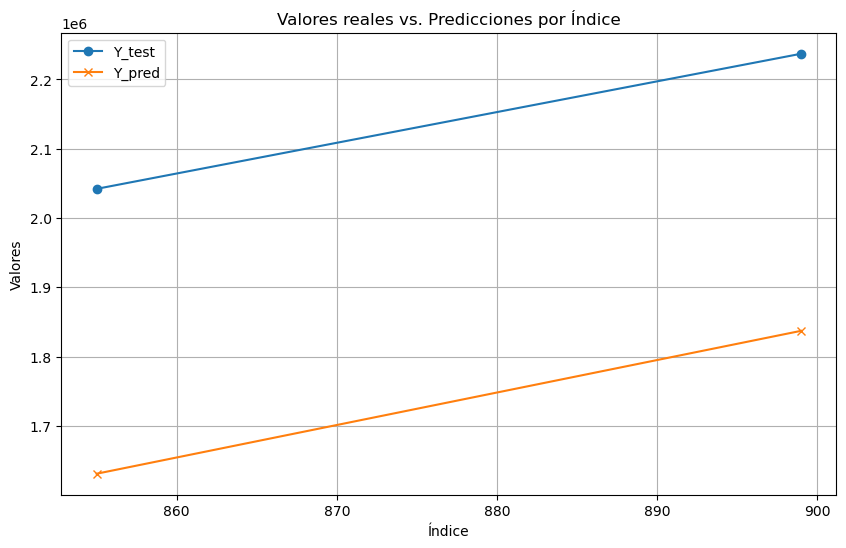

In [43]:
plt.figure(figsize=(10, 6))Se observa que los valores predichos son mas bajos que los reales, en el orden del error cuadratico medio. Sin embargo el modelo captó la tendencia de aumento en el stock migratorio. Se utilizará el modelo para crear una aplicación que determine el % de variacion del stock migratorio ante variaciones en los indicadores estudiados.
plt.plot(results_arg.index, results_arg['Y_test'], label='Y_test', marker='o')
plt.plot(results_arg.index, results_arg['Y_pred'], label='Y_pred', marker='x')
plt.xlabel('Índice')
plt.ylabel('Valores')
plt.title('Valores reales vs. Predicciones por Índice')
plt.legend()
plt.grid(True)
plt.show()

Guardo el mejor modelo para despues levantarlo e incorporarlo a la app que desarrollaremos con streamlit.

In [44]:
best_model.save_model('xgb_model_final_3.json')

Se genera un archivo csv llamado para llenar que se va usar para el deploy del modelo en streamlit

In [45]:
X.columns

Index(['Year', 'Ingresos', 'Electricidad', 'Crecimiento PBI per cápita',
       'Importaciones', 'Desempleados con educación avanzada', 'Pobreza',
       'Mortalidad', 'ISO3_dest_AFG', 'ISO3_dest_AGO',
       ...
       'ISO3_dest_UZB', 'ISO3_dest_VCT', 'ISO3_dest_VEN', 'ISO3_dest_VNM',
       'ISO3_dest_VUT', 'ISO3_dest_WSM', 'ISO3_dest_YEM', 'ISO3_dest_ZAF',
       'ISO3_dest_ZMB', 'ISO3_dest_ZWE'],
      dtype='object', length=199)

In [46]:
X.shape

(1039, 199)

In [47]:
columnas=X_train.columns
df = pd.DataFrame([0]*len(columnas), index=columnas).T
df.to_csv('para_llenar_2')

In [48]:
df

,Year,Ingresos,Electricidad,Crecimiento PBI per cápita,Importaciones,Desempleados con educación avanzada,Pobreza,Mortalidad,ISO3_dest_AFG,ISO3_dest_AGO,...,ISO3_dest_UZB,ISO3_dest_VCT,ISO3_dest_VEN,ISO3_dest_VNM,ISO3_dest_VUT,ISO3_dest_WSM,ISO3_dest_YEM,ISO3_dest_ZAF,ISO3_dest_ZMB,ISO3_dest_ZWE
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
